<a href="https://colab.research.google.com/github/aidot-kr/AISecurity/blob/master/13_BERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 구글드라이브와 Colab 연동

In [ ]:
#HuggingFace는 자연어 처리 인공지능 모델에서, BERT 모델 같은 트랜스포머 모델들을 쉽게 다룰 수 있게 해주는 패키지임
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.7 MB/s eta 0:00:00


In [ ]:
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
import spacy
import re
import nltk
import string
import sklearn
import neattext as nt
import neattext.functions as nfx
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path1 = '/content/drive/My Drive/bert/newdata0627.csv'
df = pd.read_csv(file_path1)

In [ ]:
df.rename(columns={'text': 'Text'}, inplace=True)

In [ ]:
df.head()

,Text,oh_label
0,Ain't nothing that good head or pussy that cur...,1
1,@user @user Seemed bona fide to me when I did ...,0
2,@user @user @user @user @user @user @user @use...,0
3,@USER RODRICK ISN'T EVEN THAT BAD IS THE THING...,1
4,Pretty sure I got ya bitch nudes in my phone n...,1


In [ ]:
df['oh_label'].value_counts()

1    42045
0    42045
Name: oh_label, dtype: int64

In [ ]:
# 데이터 1 칼럼 불필요 한거 없애기
df.isnull().sum()

Text        0
oh_label    0
dtype: int64

In [ ]:
print(df.isnull())

        Text  oh_label
0      False     False
1      False     False
2      False     False
3      False     False
4      False     False
...      ...       ...
84085  False     False
84086  False     False
84087  False     False
84088  False     False
84089  False     False

[84090 rows x 2 columns]


In [ ]:

from html import unescape
# Preprocess text function
def preprocess_text(text):
    # 1. Find #[xX]?\w+; and put '&' to the first
    text = re.sub(r'(^|\D)#\w+;', lambda match: f'&{match.group()}' if match.group().startswith('#') else f'{match.group()[0]}&{match.group()[1:]}', text)
    # 2. Convert HTML character to unicode
    text = unescape(text)
    # 3. Remove http, https
    text = re.sub(r'http\S+|https\S+', '', text)
    # 4. Remove email
    text = re.sub(r'\S+@\S+', '', text)
    # 5. Remove twitter id
    text = re.sub(r'@\w+', '', text)
    # 6. Remove "&lt;/b&gt;"
    text = re.sub(r'&lt;/b&gt;', '', text)
    # 7. Remove &quot; and quot;
    text = re.sub(r'&quot;|quot;', '', text)
    # 8. Replace &amp; and amp; with &
    text = re.sub(r'&amp;|amp;', '&', text)
    # 9. Replace &lt; and lt; with <
    text = re.sub(r'&lt;|lt;', '<', text)
    # 10. Replace &gt; and gt; with >
    text = re.sub(r'&gt;|gt;', '>', text)
    # 11. Remove the text inside parentheses
    text = re.sub(r'\(.*?\)', '', text)
    # 12. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # 13. Remove #
    text = re.sub(r'#[\w]*', '', text)
    # Remove user handles
    text = re.sub(r'@\w+', '', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text

In [ ]:
df['Text'] = df['Text'].apply(preprocess_text)

In [ ]:
df['Text'] = df['Text'].apply(nfx.remove_stopwords)
df.tail()

,Text,oh_label
84085,read aicle 4 yrs dhabas national highways grow...,0
84086,thankful paner.,0
84087,"playing : sophie hutchings - "" most""",0
84088,Liberals steamrolling Parliament proper debate...,1
84089,wish go!,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84090 entries, 0 to 84089
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      84090 non-null  object
 1   oh_label  84090 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [ ]:
'''
from transformers import RobertaConfig, RobertaForSequenceClassification

# 로드하려는 모델의 경로를 지정합니다.
model_path = '/content/drive/My Drive/bert/roberta_ver5'

# 이전에 저장한 모델의 설정을 로드합니다.
config = RobertaConfig.from_pretrained(model_path)

# 저장된 모델을 로드합니다.
model = RobertaForSequenceClassification.from_pretrained(model_path, config=config)

# 필요한 경우, 모델을 사용할 디바이스로 이동시킵니다.
model.to(device)


In [ ]:
#테스트 하는거 끌어온거 참조
'''from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
import torch
from torch.utils.data import DataLoader
import pandas as pd

# 데이터 불러오기
df = pd.read_csv("your_new_dataset.csv")

# 데이터 전처리 (기존 코드 참고)
df['oh_label'] = [get_onehot_label(label) for label in df['label']] # get_onehot_label: 라벨을 원핫 인코딩하는 함수

# 데이터를 텐서로 변환
labels = torch.tensor(df['oh_label'].tolist())
input_ids = torch.tensor(df['input_ids'].tolist())
attention_masks = torch.tensor(df['attention_mask'].tolist())

# 데이터셋 생성
dataset = TensorDataset(input_ids, attention_masks, labels)

# 데이터 로더 생성
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 토크나이저와 모델 불러오기
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('/content/drive/My Drive/bert/roberta_ver5', num_labels=NUM_LABELS)

# Device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 이후에는 기존에 훈련 코드를 사용하여 다시 훈련하거나 평가를 진행합니다.


## Train, Test set 나누기

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Training set size: 58863
Validation set size: 12613
Test set size: 12614


In [ ]:
df['oh_label'].value_counts()

1    42045
0    42045
Name: oh_label, dtype: int64

In [ ]:
df_test['oh_label'].value_counts()

1    6338
0    6276
Name: oh_label, dtype: int64

In [ ]:
df_train['oh_label'].value_counts()

0    29465
1    29398
Name: oh_label, dtype: int64

In [ ]:
df_val['oh_label'].value_counts()

1    6309
0    6304
Name: oh_label, dtype: int64

## 4. 버트 인풋 만들기


토큰화 확인

In [ ]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf
import numpy as np
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained('bert-large-cased')
import random

random_index = random.choice(df.index.tolist())
random_row = df.loc[random_index]

# 선택한 행의 텍스트를 토크나이징합니다
text = random_row['Text']
tokens = tokenizer.tokenize(text)

print(f"Original Text: {text}")
print(f"Tokens: {tokens}")

Original Text: beautiful princess mummy
Tokens: ['beautiful', 'princess', 'mum', '##my']


In [ ]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf
import numpy as np
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained('bert-large-cased')

SEQ_LEN = 128
BATCH_SIZE = 32
DATA_COLUMN = "Text"  # 텍스트가 있는 열의 이름으로 바꾸어야 합니다.
LABEL_COLUMN = "oh_label"  # 라벨이 있는 열의 이름으로 바꾸어야 합니다.


def convert_data(data_df):
    tokens, masks, segments, targets = [], [], [], []


    for index, row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        token = tokenizer.encode(row[DATA_COLUMN], max_length=SEQ_LEN, truncation=True, padding='max_length')
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(row[LABEL_COLUMN])

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets



# df_train 변환
train_x, train_y = convert_data(df_train)

# df_val 변환
val_x, val_y = convert_data(df_val)

# df_test 변환
test_x, test_y = convert_data(df_test)


100%|██████████| 12614/12614 [00:03<00:00, 4004.77it/s]


사전학습된 버트 모델의 인풋은 문장 토큰화가 숫자로 바뀐 것과, 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터가 들어갑니다. 우리는 문장 하나를 가지고만 훈련할 것이므로 순서 벡터는 모두 0으로 통일합니다.

그리고 파인튜닝 시에는 문장 안에 일부 단어를 가리는 마스킹은 사용하지 않습니다.

In [ ]:
train_x

[array([[ 101, 1376, 1844, ...,    0,    0,    0],
        [ 101,  169,  169, ...,    0,    0,    0],
        [ 101,  134,  134, ...,    0,    0,    0],
        ...,
        [ 101,  134,  134, ...,    0,    0,    0],
        [ 101, 6416, 9553, ...,    0,    0,    0],
        [ 101,  134,  134, ...,    0,    0,    0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

## 여기서부터는 테스트

버트 모형에 들어갈 인풋은 토큰, 세그먼트, 포지션으로 구성됩니다.
버트에 인풋으로 들어가는 토큰은 문장을 토크나이징 한 후, 인덱스 번호를 매긴 것입니다.
세그먼트는 예를 들어 문장이 두 개가 있다면, 앞의 문장과 뒤의 문장을 구분하는 것입니다.
포지션 임베딩은 단순히 단어의 위치를 말합니다.

토큰, 세그먼트, 포지션을 인풋으로 버트 모형에 넣으면 기하학적인 문장 공간으로 임베딩이 됩니다.

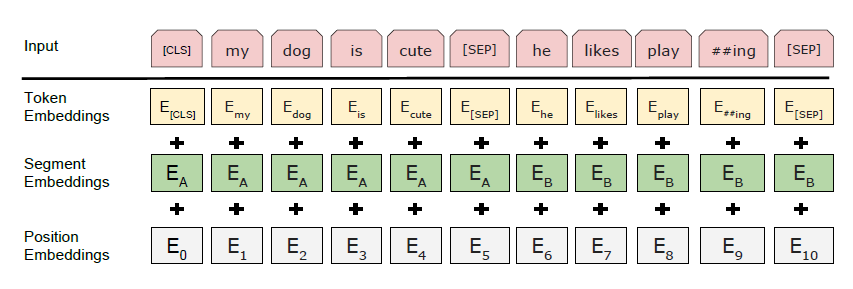

이해가 안 가실 수 있는데, 버트 인풋을 문장으로 예를 들어 만들어 보겠습니다.
인풋은 총 2개가 들어갑니다

* (토큰) 첫번째 인풋은 토큰화 된 것이 인덱싱되어 숫자로 변환된 것

* (세그멘트) 두번째 인풋은 앞문장인지 뒷문장인지 알려주는 숫자들입니다. 이번 튜토리얼에서는 파인튜닝 과정이라 앞문장 뒷문장 구분을 안하기 때문에 모두 0으로 하였습니다.

* (포지션) 단어 순서에 따라서 자동으로 부여됩니다.

# 버트를 활용한 스팸분석 모델 만들기
버트 훈련을 빠르게 하기 위해, TPU를 사용하도록 하겠습니다

In [ ]:
# TPU 객체 지정
TPU = True
if TPU:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
else:
  pass

In [ ]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.6 MB/s eta 0:00:00


In [ ]:
# Rectified Adam 옵티마이저 사용
import tensorflow_addons as tfa
opt = tfa.optimizers.RectifiedAdam(lr=1.0e-5, weight_decay=0.0025)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:121: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
from transformers import BertConfig, TFBertModel

def create_malicious_comment_bert():
    # BertConfig를 사용하여 커스텀 설정 생성
    config = BertConfig.from_pretrained('bert-large-cased', hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)

    # 이 커스텀 설정을 사용하여 버트 pretrained 모델 로드
    model = TFBertModel.from_pretrained('bert-large-cased', config=config)

    # 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
    token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
    mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
    segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')

    # 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
    bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

    bert_outputs = bert_outputs[1]
    malicious_comment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(bert_outputs)
    malicious_comment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], malicious_comment_first)

    malicious_comment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return malicious_comment_model

In [ ]:
# 모델 생성
malicious_comment_model = create_malicious_comment_bert()

# 가중치 로드
malicious_comment_model.load_weights('/content/drive/My Drive/bert/malicious_comment_model_(large)_new1.h5')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# import os
import tensorflow as tf

# TPU 사용 여부 설정
TPU = True

if TPU:
    # TPU 클러스터의 리졸버 설정
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)

    with strategy.scope():
        malicious_comment_model = create_malicious_comment_bert()
else:
    malicious_comment_model = create_malicious_comment_bert()
# 모델 학습
history = malicious_comment_model.fit(train_x, train_y, epochs=5, shuffle=True, batch_size=BATCH_SIZE, validation_data=(val_x, val_y))

# 결과 평가
result = malicious_comment_model.evaluate(test_x, test_y)
print(result)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/5
1840/1840 [==============================] - 632s 245ms/step - loss: 0.4265 - accuracy: 0.7968 - val_loss: 0.3734 - val_accuracy: 0.8244
Epoch 2/5
1840/1840 [==============================] - 349s 190ms/step - loss: 0.3339 - accuracy: 0.8504 - val_loss: 0.3426 - val_accuracy: 0.8410
Epoch 3/5
1840/1840 [==============================] - 349s 190ms/step - loss: 0.2605 - accuracy: 0.8881 - val_loss: 0.3343 - val_accuracy: 0.8594
Epoch 4/5
1840/1840 [==============================] - 348s 189ms/step - loss: 0.1831 - accuracy: 0.9234 - val_loss: 0.3734 - val_accuracy: 0.8621
Epoch 5/5
395/395 [==============================] - 18s 44ms/step - loss: 0.4193 - accuracy: 0.8657
[0.41928011178970337, 0.8657047748565674]


In [ ]:
# 모델 평가
result = malicious_comment_model.evaluate(test_x, test_y)
print(result)

import random
random_index = random.choice(df.index.tolist())
random_row = df.loc[random_index]

# 선택한 행의 텍스트를 토크나이징합니다
text = random_row['Text']
tokens = tokenizer.tokenize(text)

print(f"Original Text: {text}")
print(f"Tokens: {tokens}")

# 선택한 행의 텍스트를 모델에 입력할 형태로 전처리합니다
inputs = tokenizer.encode_plus(text, return_tensors='tf', max_length=SEQ_LEN, truncation=True, padding='max_length')

# 모델로 예측을 진행합니다
prediction = malicious_comment_model.predict([inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids']])

# 예측 결과를 출력합니다
print(f"Prediction: {prediction}")


395/395 [==============================] - 18s 44ms/step - loss: 0.4193 - accuracy: 0.8657
[0.41928011178970337, 0.8657047748565674]
Original Text: Song EU, cash remaining chips p*ss 👍 played cards liberals U.S too. Brexiteers Trump takes nice eh life'll better everyone. URL
Tokens: ['Song', 'EU', ',', 'cash', 'remaining', 'chips', 'p', '*', 's', '##s', '[UNK]', 'played', 'cards', 'liberal', '##s', 'U', '.', 'S', 'too', '.', 'B', '##re', '##xi', '##tee', '##rs', 'Trump', 'takes', 'nice', 'eh', 'life', "'", 'll', 'better', 'everyone', '.', 'U', '##RL']
1/1 [==============================] - 16s 16s/step
Prediction: [[0.59539056]]


In [ ]:
# predict_load_data 함수 정의
def predict_load_data(df):
    tokens, masks, segments = [], [], []

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        text = row['Text']
        token = tokenizer.encode(text, max_length=SEQ_LEN, truncation=True, padding='max_length')
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)

    return [tokens, masks, segments]

# 테스트 데이터 변환
test_x = predict_load_data(df_test)

# 예측
predictions = malicious_comment_model.predict(test_x)

# 실제 값
y_true = df_test['oh_label']

# F1 Score 확인
from sklearn.metrics import classification_report
print(classification_report(y_true, np.round(predictions,0), digits=3))


100%|██████████| 12614/12614 [00:03<00:00, 4063.08it/s]


395/395 [==============================] - 38s 79ms/step
              precision    recall  f1-score   support

           0      0.847     0.891     0.868      6276
           1      0.886     0.840     0.863      6338

    accuracy                          0.866     12614
   macro avg      0.867     0.866     0.866     12614
weighted avg      0.867     0.866     0.866     12614



훈련 및 성능 검증

In [ ]:
# 모델 저장
malicious_comment_model.save_weights('/content/drive/My Drive/bert/malicious_comment_model_new3.h5')


In [ ]:
def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []

    for index, row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        token = tokenizer.encode(row[DATA_COLUMN], max_length=SEQ_LEN, truncation=True, padding='max_length')
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def predict_load_data(pandas_dataframe):
    data_df = pandas_dataframe.copy()  # 입력 데이터프레임을 복사하여 원본 데이터를 변경하지 않도록 합니다.
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x


In [ ]:
test_x = predict_load_data(df_test)
predictions = malicious_comment_model.predict(test_x)


100%|██████████| 21755/21755 [00:17<00:00, 1247.98it/s]


680/680 [==============================] - 23s 27ms/step


In [ ]:
test_x

[array([[  101,  1107, 13782, ...,     0,     0,     0],
        [  101,   134,   134, ...,     0,     0,     0],
        [  101,  4819,   171, ...,     0,     0,     0],
        ...,
        [  101,   131,   131, ...,     0,     0,     0],
        [  101,   134,   134, ...,     0,     0,     0],
        [  101,  2993,  1681, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [ ]:
with strategy.scope():
  preds = malicious_comment_model.predict(test_x)


680/680 [==============================] - 14s 20ms/step


In [ ]:
# 스팸이면 1, 정상이면 0 출력
preds

array([[9.0224874e-01],
       [1.1320734e-01],
       [9.9945784e-01],
       ...,
       [9.9935794e-01],
       [2.1085143e-04],
       [9.9695939e-01]], dtype=float32)

우리가 훈련한 모델을 F1 SCORE를 바탕으로 성능 측정
F1 SCORE는 precision과 recall을 가중평균하여 계산합니다
recall은 (모델이 TRUE라고 판정한 것의 숫자)/(전체 TRUE의 숫자)
precision은 (진짜 TRUE) / (모델이 TRUE라고 판정한 것의 숫자)

In [ ]:
from sklearn.metrics import classification_report
y_true = df_test['oh_label']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0), digits=3))

NameError: ignored

In [ ]:
import logging
tf.get_logger().setLevel(logging.ERROR)

실제 데이터로 실습하기

In [ ]:
def sentence_convert_data(data):
    global tokenizer
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN, truncation=True, padding='max_length')

    num_zeros = token.count(0)
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
    segment = [0]*SEQ_LEN

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def malicious_comment_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = malicious_comment_model.predict(data_x)
    predict_value = np.ravel(predict)
    predict_answer = np.round(predict_value).astype(int).item()  # 수정된 부분

    if predict_answer == 1:  # 수정된 부분
        print("(rate : %.2f) Malicious comment." % predict_value)
    elif predict_answer == 0:  # 수정된 부분
        print("(rate : %.2f) Non-malicious comment." % predict_value)




In [ ]:
def predict_random_data(df):
    random_index = random.choice(df.index.tolist())
    random_text = df.loc[random_index, 'Text']
    prediction = malicious_comment_evaluation_predict(random_text)
    return random_text, prediction
random_text, prediction = predict_random_data(df)
print("Text:", random_text)
print("Prediction:", prediction)


1/1 [==============================] - 1s 636ms/step
(rate : 0.05) Non-malicious comment.
Text: PKK terrorist list Peshmerga.
Prediction: None


In [ ]:
malicious_comment_evaluation_predict("I'm sexist")


1/1 [==============================] - 1s 532ms/step
(rate : 0.96) Malicious comment.


In [ ]:
malicious_comment_evaluation_predict("You fuck your dad")


1/1 [==============================] - 1s 555ms/step
(rate : 0.83) Malicious comment.


In [ ]:
malicious_comment_evaluation_predict("fuck your dad")

1/1 [==============================] - 1s 514ms/step
(rate : 0.38) Non-malicious comment.


In [ ]:
malicious_comment_evaluation_predict("hi")

1/1 [==============================] - 1s 531ms/step
(rate : 0.05) Non-malicious comment.


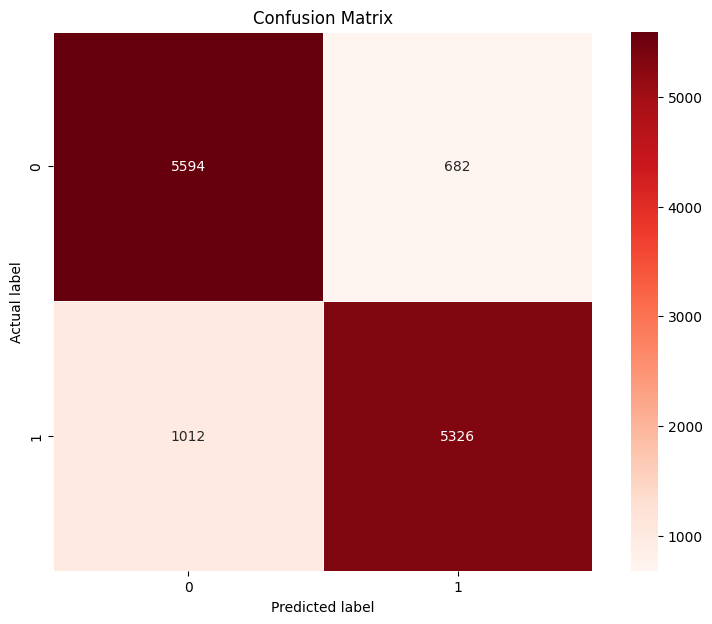

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predicted values
y_pred = np.round(predictions, 0)

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Reds')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

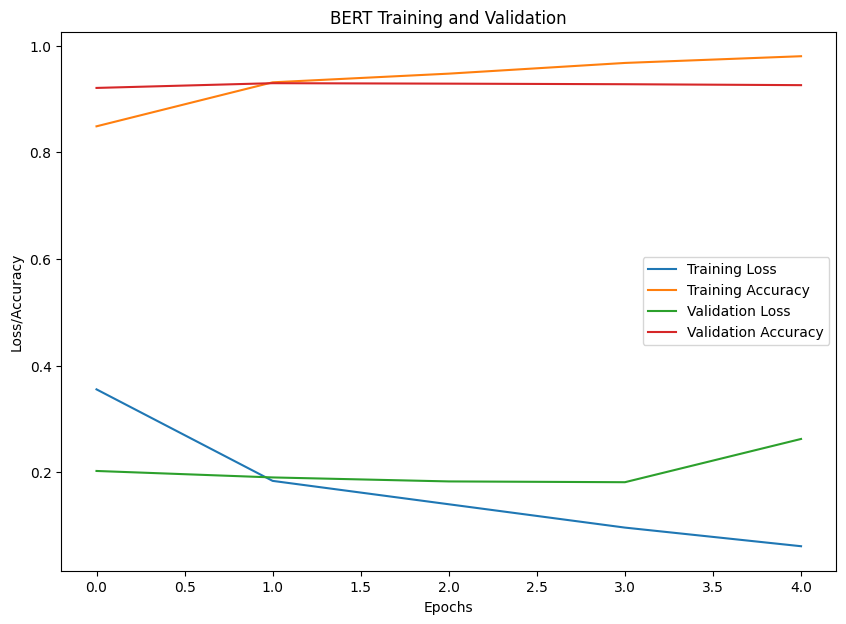

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")

plt.title('BERT Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()
